In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [11]:
data = pd.read_csv('lab2_1_data.csv', header=None).to_numpy()

data.shape

(2, 100)

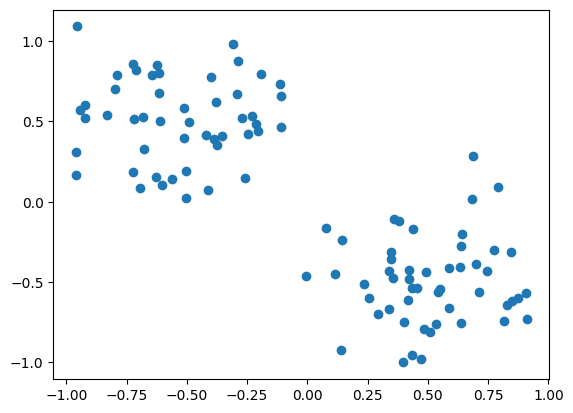

In [12]:
plt.scatter(data[0], data[1])

In [13]:
W = np.random.rand(data.shape[0])

W.shape

(2,)

In [14]:
def plot(data, weights_list, title=''):
    w_x, w_y, w_norms = [], [], []
    for w in weights_list:
        w_x.append(w[0])
        w_y.append(w[1])
        w_norms.append(np.linalg.norm(w, 2))

    plt.figure(figsize=(20, 20))
    plt.suptitle(title)
    C = np.corrcoef(data)
    evals, evects = np.linalg.eig(C)
    PC = evects.T[evals.argmax()]

    ax = plt.subplot(3, 2, 1)
    ax.set_title('Data distribution, W and first component of PCA')
    plt.grid(True)
    ax.scatter(data[0], data[1])
    ax.quiver(*weights_list[-1], color='r')
    ax.quiver(PC[0], PC[1])

    x = list(range(len(weights_list)))
    ax = plt.subplot(3, 2, 2)
    ax.set_title('W norm')
    plt.grid(True)
    ax.plot(x, w_norms)

    ax = plt.subplot(3, 2, 3)
    ax.set_title('W first component - x axis')
    plt.grid(True)
    ax.plot(x, w_x)

    ax = plt.subplot(3, 2, 4)
    ax.set_title('W second component - y axis')
    plt.grid(True)
    ax.plot(x, w_y)

    ax = plt.subplot(3, 2, 5)
    ax.set_title('W sum')
    plt.grid(True)
    ax.plot(x, [w[0] + w[1] for w in weights_list])

In [15]:
def train(data, w, learning_rule, epochs=500, lr=1e-3):
    weights_list = [w]
    for epoch in range(epochs):
        data = np.random.permutation(data.T).T
        for u in data.T:
            v = w.T @ u
            delta_w = learning_rule(v, u, w)
            w = w + lr * delta_w
            weights_list.append(w)
    return weights_list

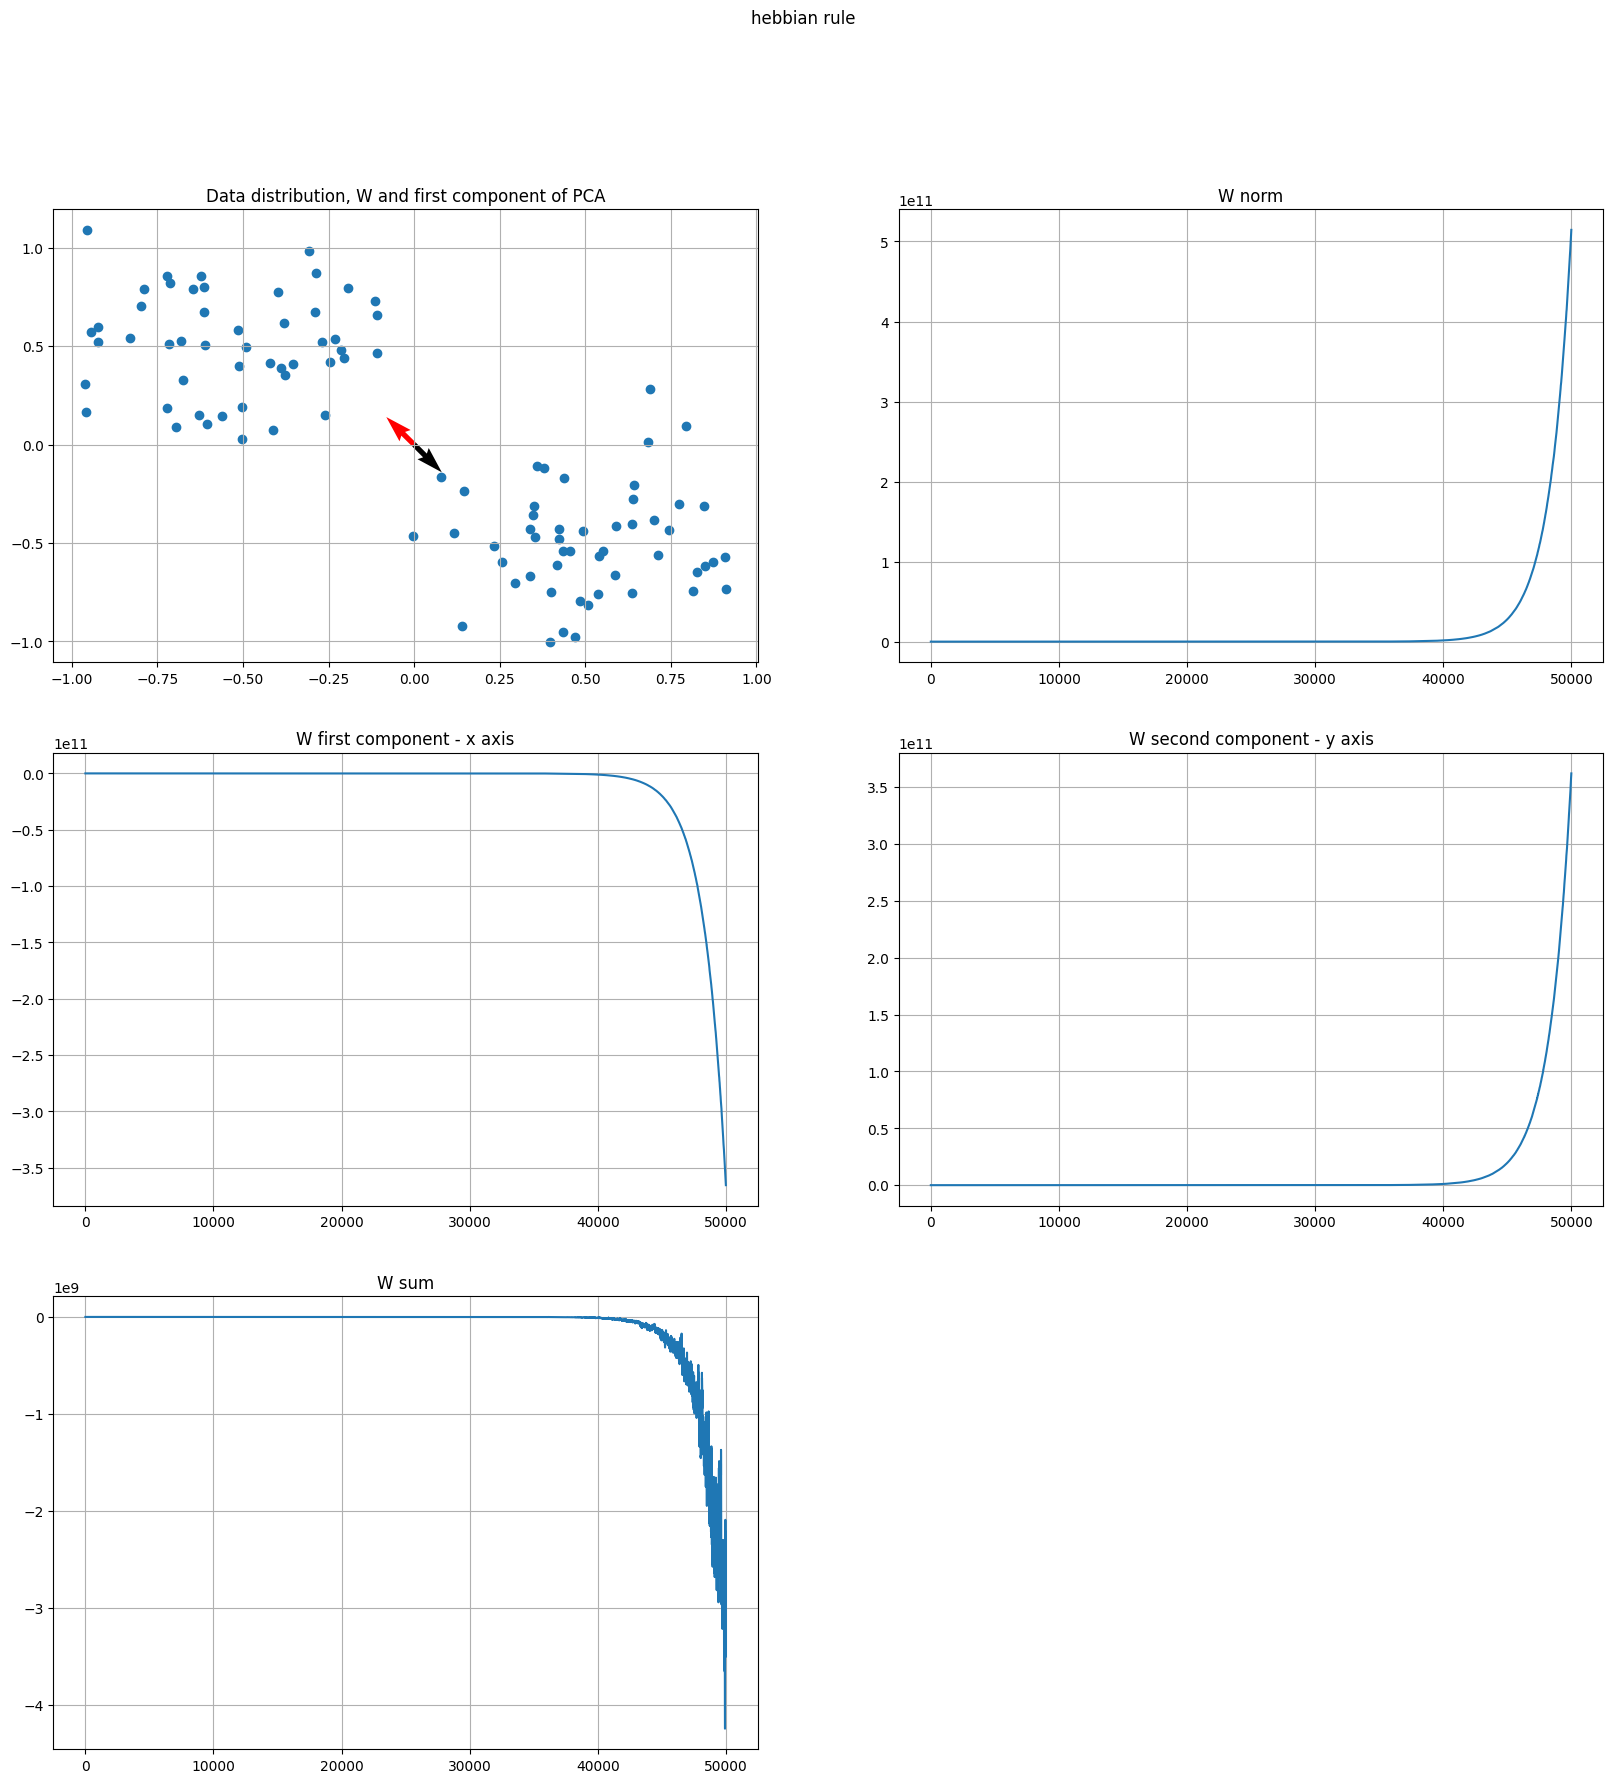

In [16]:
hebbian_rule = lambda v, u, w: v * u

weights_over_time = train(data, W, learning_rule=hebbian_rule)
plot(data, weights_over_time, title='hebbian rule')

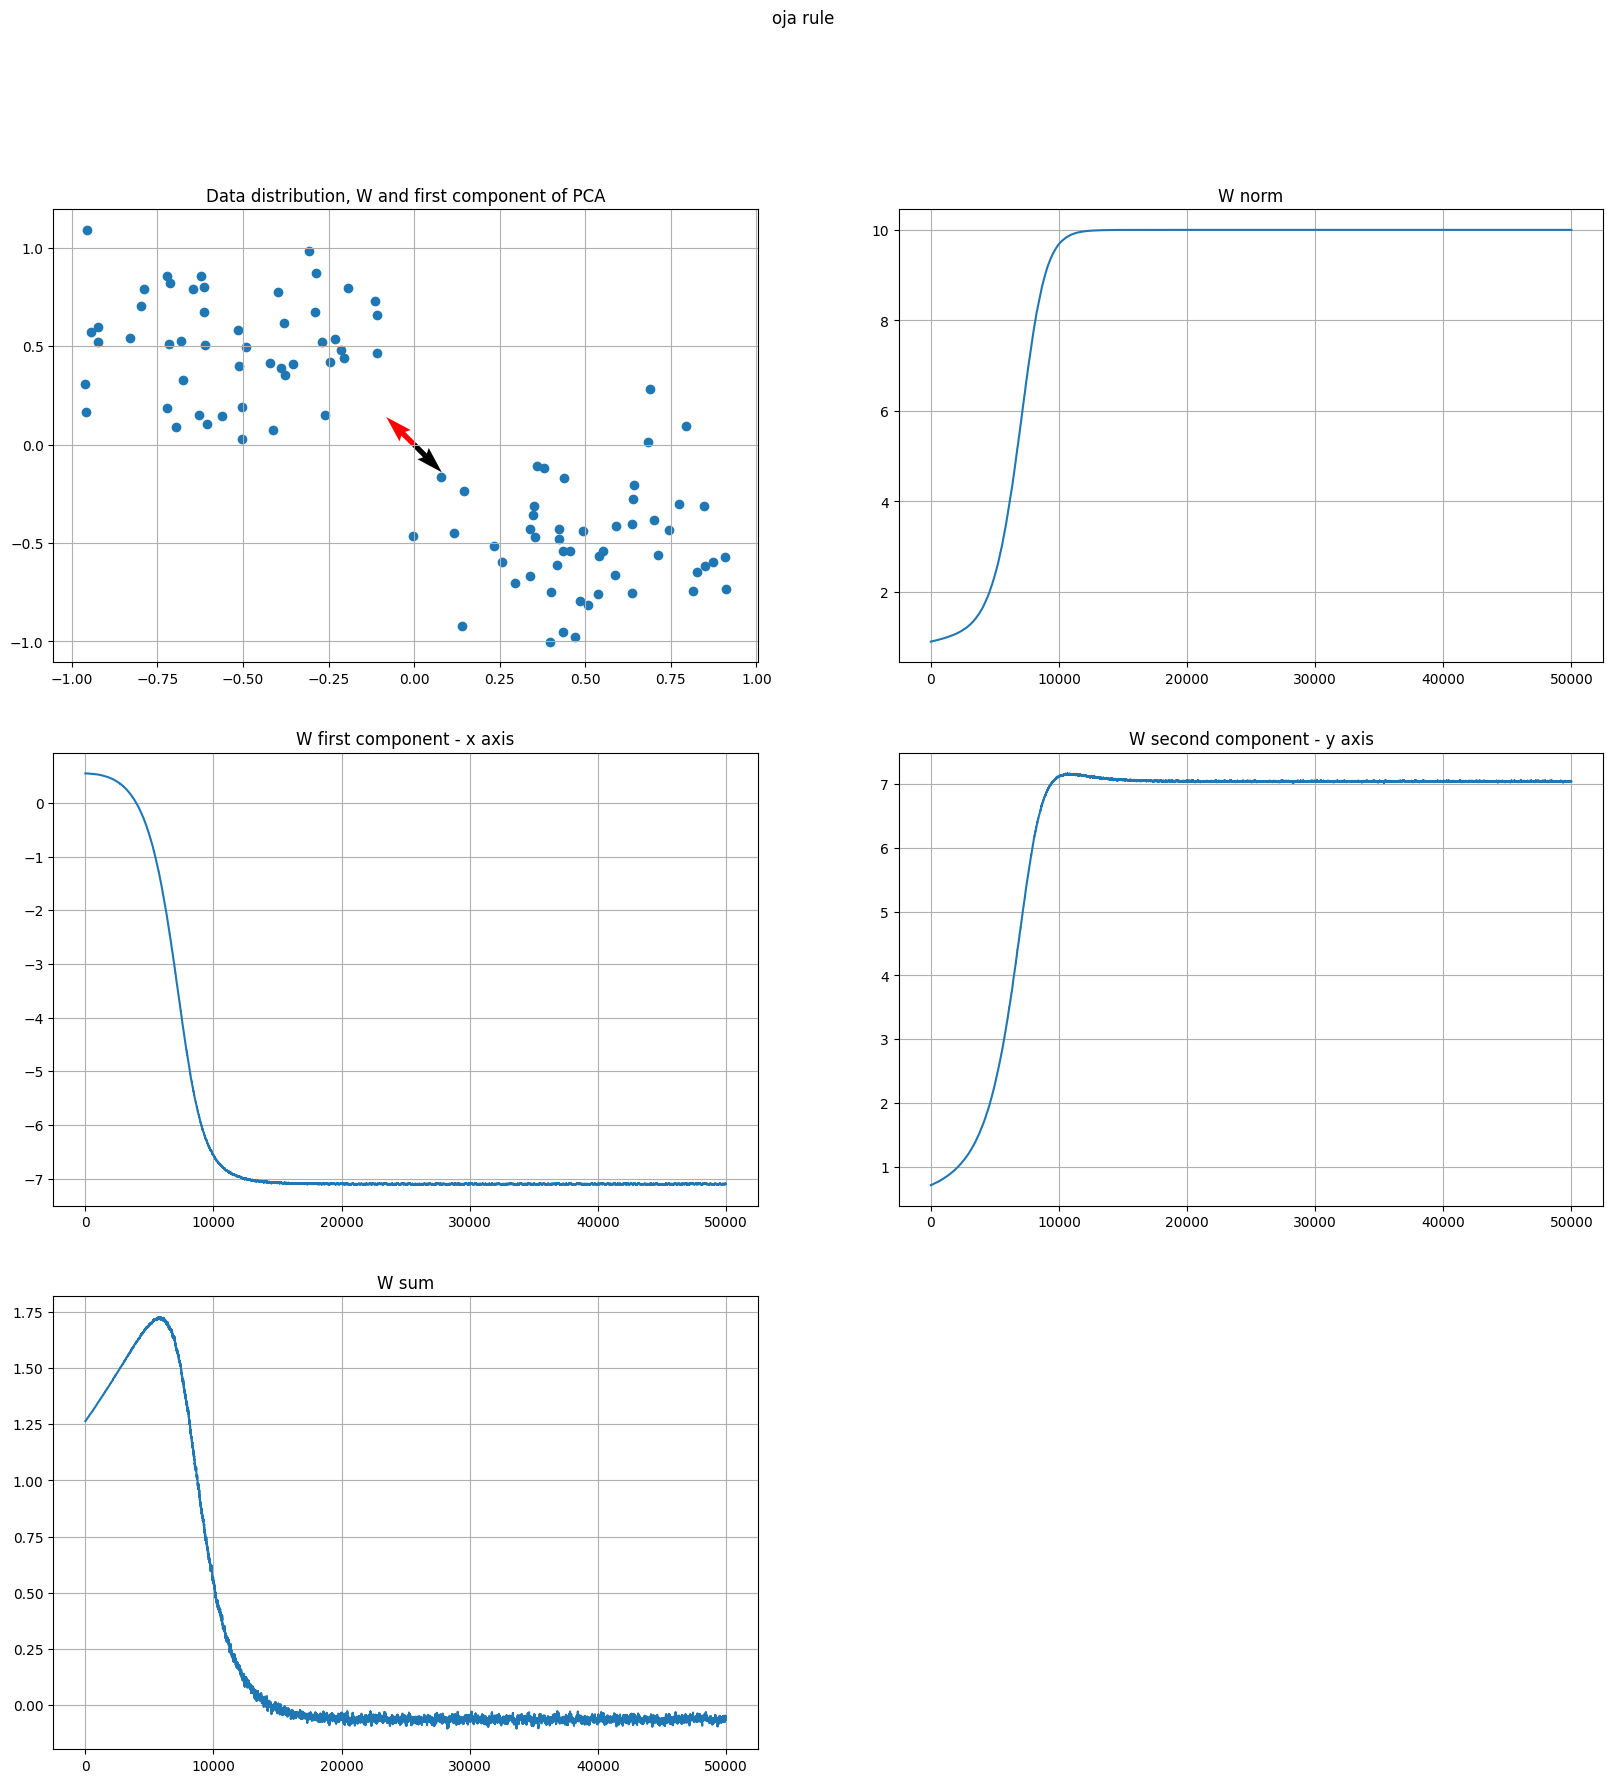

In [17]:
alpha = 0.01
oja_rule = lambda v, u, w: v * u - alpha * v ** 2 * w

weights_over_time = train(data, W, learning_rule=oja_rule)
plot(data, weights_over_time, title='oja rule')

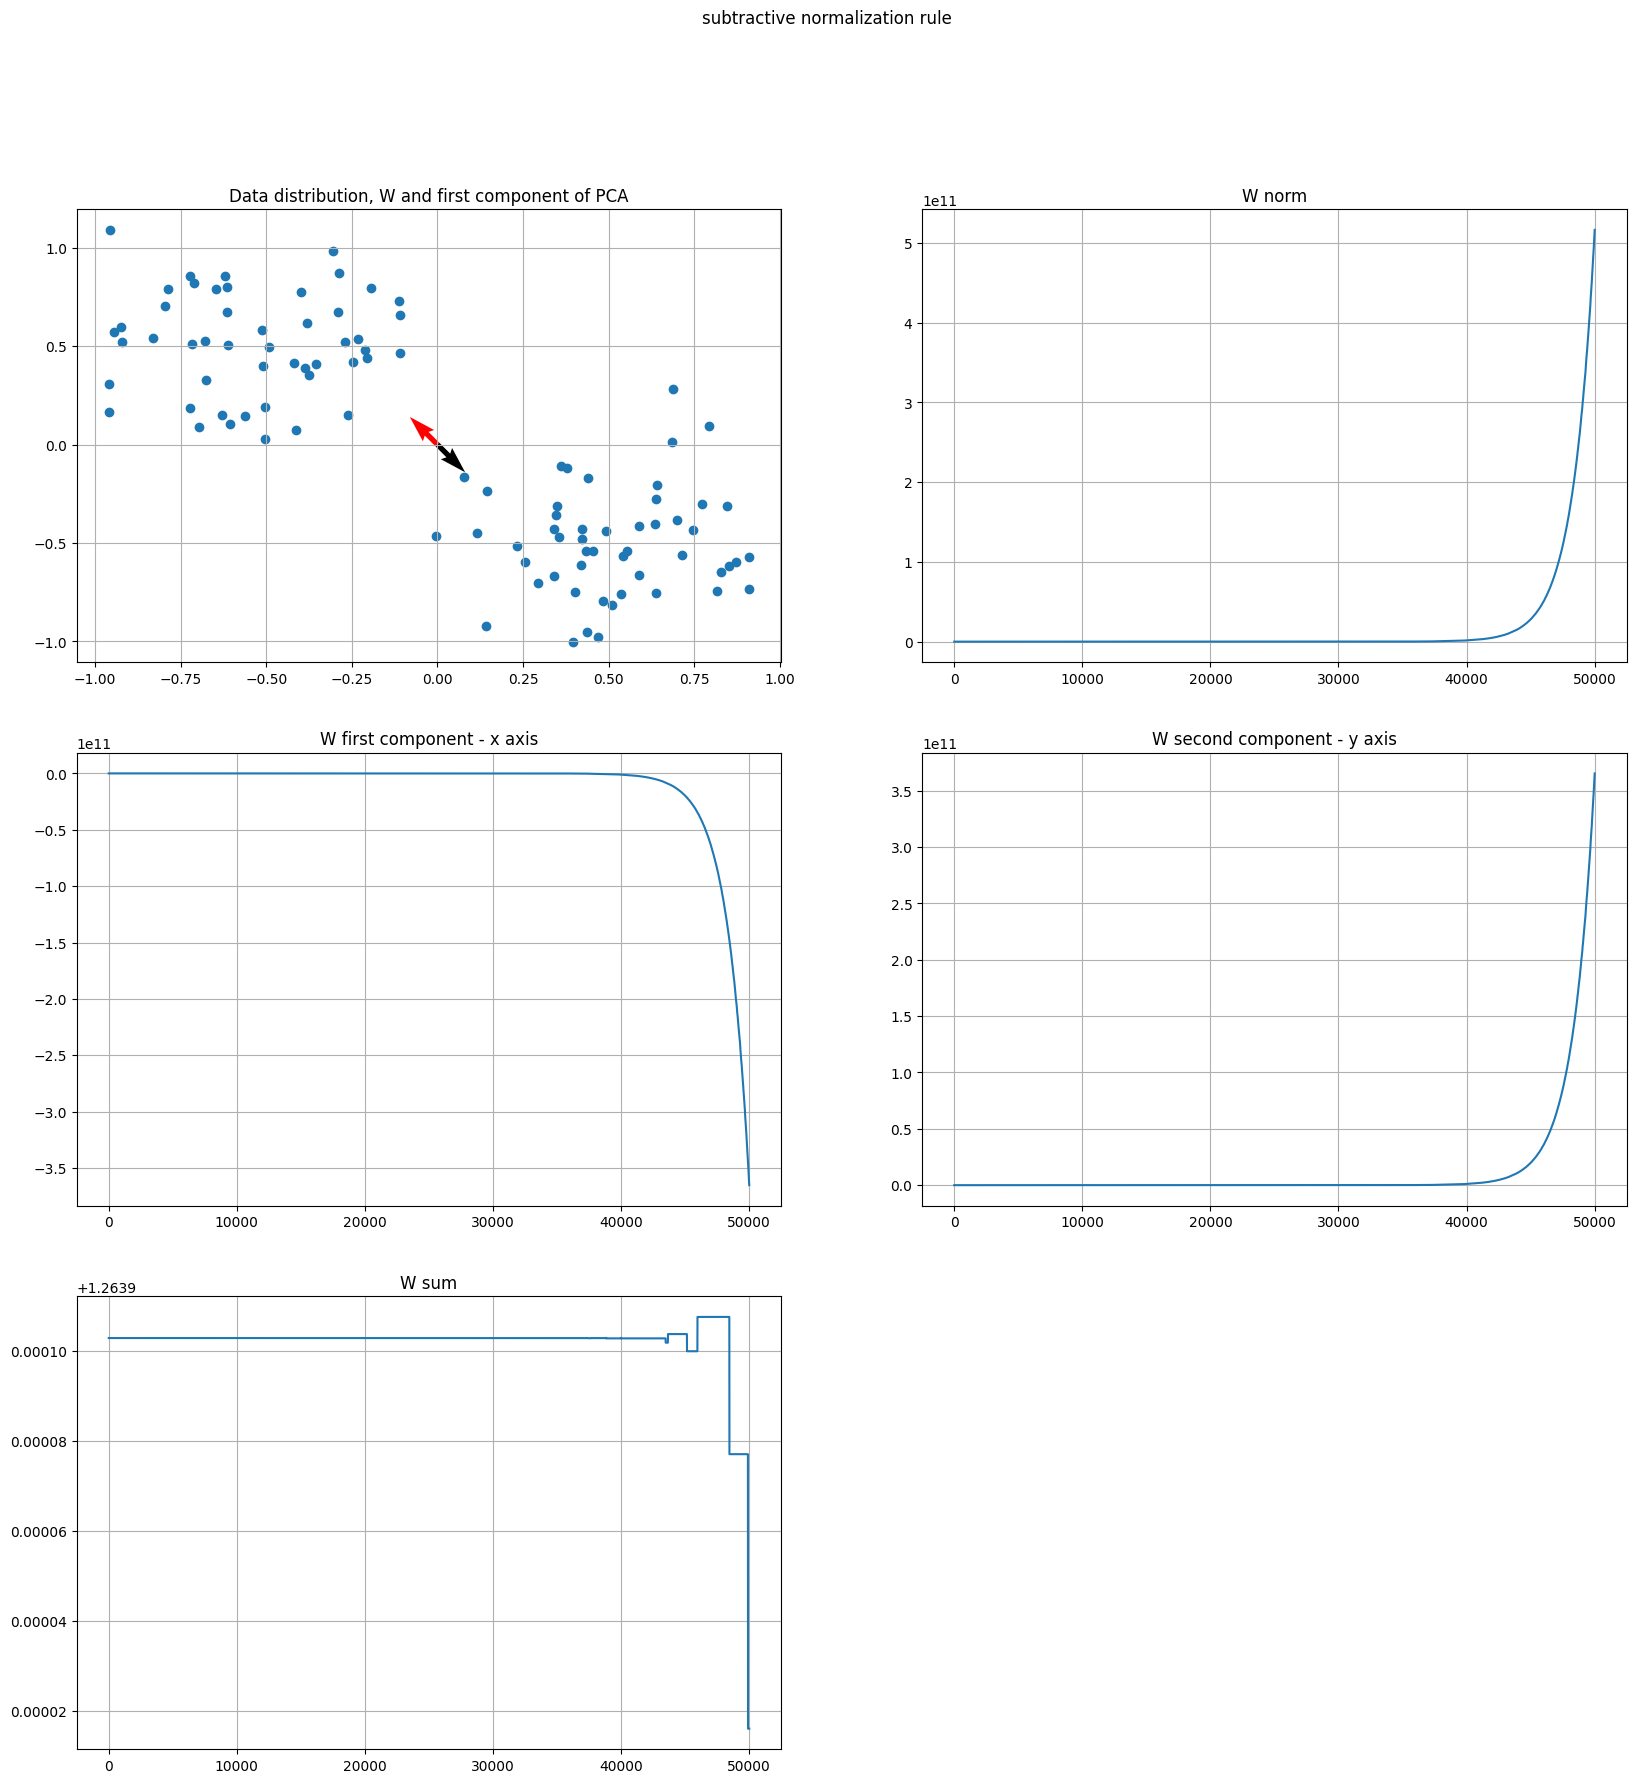

In [18]:
n = np.ones(data.shape[0])
subtractive_normalization = lambda v, u, w: v * u - ((v * (n.T @ u) * n) / 2)

weights_over_time = train(data, W, learning_rule=subtractive_normalization)
plot(data, weights_over_time, title='subtractive normalization rule')